In [1]:
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import sys
import numpy as np
import pandas as pd
#sys.path.append('/home/ak/ThesisCode/hsmm/')
sys.path.append('/home/kman/Research/hsmm/') 
sys.path.append('/home/ak/Documents/Research/hsmm/hsmm/') 

from hsmm_core.observation_models import * 
from hsmm_core.hmm import *
from hsmm_core.hmm_utils import load_data
from hsmm_core.prediction_engines import *
import glob
import seaborn
import matplotlib.pyplot as plt


In [3]:
import os
eem_path = '/home/ak/Documents/Data/EEM/'
#os.listdir(eem_path)
os.chdir(eem_path)
eem_files =glob.glob('*.csv')
type(eem_files)
print eem_files

['20131231.csv', '20131218.csv', '20140508.csv', '20140424.csv', '20131028.csv', '20140417.csv', '20131126.csv', '20131004.csv', '20140331.csv', '20131024.csv', '20140421.csv', '20130612.csv', '20140321.csv', '20130717.csv', '20130607.csv', '20131129.csv', '20140206.csv', '20140117.csv', '20131105.csv', '20130624.csv', '20130617.csv', '20131122.csv', '20130618.csv', '20131213.csv', '20131018.csv', '20131108.csv', '20131212.csv', '20140114.csv', '20130903.csv', '20131023.csv', '20130815.csv', '20130807.csv', '20130806.csv', '20131016.csv', '20131114.csv', '20131224.csv', '20140428.csv', '20140314.csv', '20130605.csv', '20140203.csv', '20140507.csv', '20140515.csv', '20130813.csv', '20140521.csv', '20140212.csv', '20130703.csv', '20140108.csv', '20130603.csv', '20140226.csv', '20140505.csv', '20130731.csv', '20130712.csv', '20130826.csv', '20140303.csv', '20130904.csv', '20130924.csv', '20130917.csv', '20131106.csv', '20130823.csv', '20130820.csv']


In [9]:
ticker = 'EEM'
n_hidden_states = 2

zero_pc_threshold = 1e-5
init_params = {
    "obs_model_params": {
                                'epsilon': zero_pc_threshold,
                                'obs_model_name': 'ExpUniGauss',
                                'init_params': {'epsilon': zero_pc_threshold},
                                'em_initialization_method': initialization_method.cluster

    },
    "hidden_model_params": {
                                'no_hidden_states': n_hidden_states,
                                # 'pi':startprob,
                                # 'tpm': transmat
                                'em_initialization_method': initialization_method.uniform
    },
    "update_tag": 'tpsml'
}

#data_dic, data_sampling_tag = load_data(ticker, resample=None,
 #                                      file_name=['20140122.csv'],
  #                                     load_columns=['Duration', 'ReturnTradedPrice'])

data_dic, data_sampling_tag = load_data(ticker, resample=None,
                                       file_name=eem_files,
                                       load_columns=['Duration', 'ReturnTradedPrice'])


In [10]:
hmm_calibration_engine = hmm_calibration(no_parallel_procs=None,
                                         init_params=init_params)
                                        
trained_hmms = hmm_calibration_engine.hmm_fit_func(ticker, data_dic_2,'resample__', force_recalc=False)

In [11]:
#make it a dicitonary and grab an example  
trained_hmms = dict(trained_hmms)  #[] 

print "transition matrix", '\n' 
print trained_hmms['20140314'].tpm_

print "state initial distribution", '\n' 
print trained_hmms['20140314'].pi_

print "observation model", "\n"
# notice how we use introspection to get all the attributes! this way you can see whats there and grab sigmas etc
print trained_hmms['20140314'].obs_model_.__dict__
print trained_hmms['20140314'].obs_model_.__dict__['sigmas_']


transition matrix 

[[ 0.88609957  0.11390043]
 [ 0.53860001  0.46139999]]
state initial distribution 

[ 0.99765612  0.00234388]
observation model 

{'load_columns_': ['TradedTime', 'Duration', 'ReturnTradedPrice'], 'n_features_': 2, 'n_hidden_states_': 2, 'sigmas_': array([ 0.00015673,  0.00035701]), 'update_tag_all_': 'lqsw', 'min_sigma_': 0.001, 'weight_': array([ 0.44050066,  0.75549555]), 'no_params_per_state_': 3, 'epsilon_': 1e-05, 'lambdas_': array([ 6.8307333 ,  0.30739543])}
[ 0.00015673  0.00035701]


In [12]:
a_model = trained_hmms['20131231']
a_model.map_metrics(data_dic['20131231'])

{'local_optimal_state': array([1, 1, 1, ..., 1, 1, 1]),
 'smooth_local_optimal_state': array([1, 1, 1, ..., 1, 1, 1]),
 'viterbi_optimal_state_seq': array([1, 1, 1, ..., 1, 1, 1])}

In [11]:
dates =list(trained_hmms)
state_sigmas =[]
state_lambdas =[]
for date in dates:
        sigmas= trained_hmms[date].obs_model_.__dict__['sigmas_']
        lambdas= trained_hmms[date].obs_model_.__dict__['lambdas_']
        state_sigmas.append(sigmas*1000)
        state_lambdas.append(lambdas)

In [12]:
state_sigmas =pd.DataFrame(state_sigmas)
state_lambdas =pd.DataFrame(state_lambdas)

In [13]:
state_sigmas.columns=['sigma_st_1','sigma_st_2']
state_lambdas.columns=['lambda_st_1','lambda_st_2']
sigmas_1, lambdas_1 =state_sigmas['sigma_st_1'], state_lambdas['lambda_st_1']
sigmas_2, lambdas_2 =state_sigmas['sigma_st_2'], state_lambdas['lambda_st_2']
state_components =pd.DataFrame([sigmas_1, lambdas_1,sigmas_2, lambdas_2]).T

In [14]:

state_components['sig_st1>sig_st2'] = np.where(state_components['sigma_st_1']>state_components['sigma_st_2'], 1, 0)

In [15]:
#state_components.drop('HighSigmaLowDuration', axis=1, inplace=True)
HLSD=state_components[(state_components['sigma_st_1']>state_components['sigma_st_2']) & (state_components['lambda_st_2']> state_components['lambda_st_1'])]
HLHD=state_components[(state_components['sigma_st_1']>state_components['sigma_st_2']) & (state_components['lambda_st_1']> state_components['lambda_st_2'])]
LSLD=state_components[(state_components['sigma_st_1']<state_components['sigma_st_2']) & (state_components['lambda_st_1']< state_components['lambda_st_2'])]
LSHD=state_components[(state_components['sigma_st_1']<state_components['sigma_st_2']) & (state_components['lambda_st_1']> state_components['lambda_st_2'])]

In [16]:
print HLSD.shape
print HLHD.shape
print LSLD.shape
print LSHD.shape

(8, 5)
(0, 5)
(2, 5)
(50, 5)


KeyError: 0

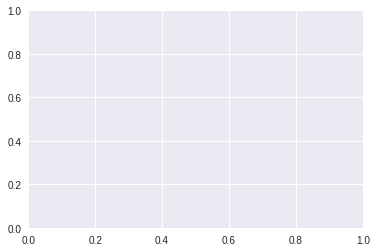

In [39]:
HLSD_sigma=HLSD['sigma_st_1']/HLSD['sigma_st_2']
HLSD_lambda=HLSD['lambda_st_1']/HLSD['lambda_st_2']
fig=plt.figure()
ax=fig.add_subplot(111)
width=0.5
ax.bar(HLSD_lambda,HLSD_sigma, align='center')

In [17]:
state_components.shape

(60, 5)

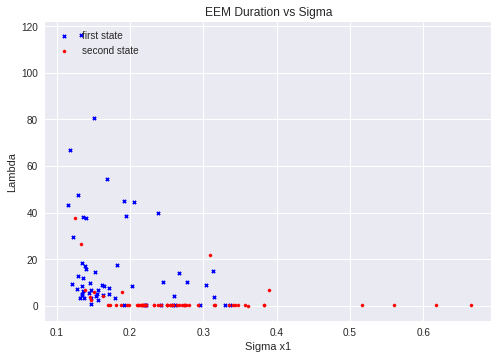

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(state_sigmas['sigma_st_1'], state_lambdas['lambda_st_1'], s=10, c='b', marker="x", label='first state')
ax1.scatter(state_sigmas['sigma_st_2'], state_lambdas['lambda_st_2'], s=10, c='r', marker="o", label='second state')
plt.legend(loc='upper left');
plt.xlabel('Sigma x1')
plt.ylabel('Lambda')
plt.title('EEM Duration vs Sigma')
plt.show()

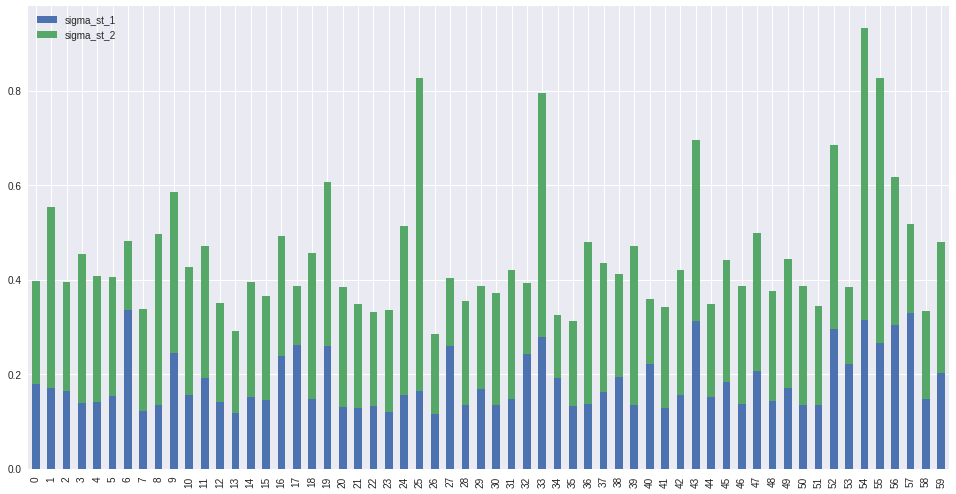

In [22]:
state_sigmas.plot(kind='bar',stacked=True); #plt.axhline(0, color='k',figsize=(8, 6))
fig = plt.gcf()
fig.set_size_inches(16.5, 8.5)
plt.figure(num=None,dpi=80, facecolor='w', edgecolor='k')

In [23]:
import scipy.stats as scp

In [24]:
print scp.spearmanr(sigmas_1,lambdas_1)
print scp.kendalltau(sigmas_1,lambdas_1)
print scp.spearmanr(sigmas_2,lambdas_2)
print scp.kendalltau(sigmas_2,lambdas_2)

SpearmanrResult(correlation=-0.37616004445679363, pvalue=0.0030559603126974417)
KendalltauResult(correlation=-0.26666666666666666, pvalue=0.0026091934700477886)
SpearmanrResult(correlation=-0.44979160878021679, pvalue=0.00031152030190610203)
KendalltauResult(correlation=-0.32768361581920902, pvalue=0.00021628168523844004)
